# Title

Short description coming soon...

## Import and Functions

In [1]:
# For paths
import os 

# For data processing
import torch
import numpy as np
from torch.utils.data import Dataset
import math
import random

# For 3D visualization
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d

## Functions

In [2]:
# Setting the root for this repo
ROOT = os.path.realpath("..")

# Create norm of passed vector
def norm_vec(vector):
    '''
    input:
    - vector: 1x3-array of vector to be normed
    
    return:
    - vector norm
    '''
    return np.linalg.norm(vector)

# Creating unit vector for input vector
def unit_vector(vector):
    '''
    input:
    - vector: 1x3-array of vector to be unitized
    
    output:
    - 1x3-array of unit vector from passed vector
    '''
    return vector / np.linalg.norm(vector)

# Determine coordinates of center of given cuboid corner coordinates
def get_cuboid_center(cuboid_corner_coordinates):
    '''
    Creates 1x3-coordiantes of the cuboid center, based on its corner values.
    '''
    center_x_coord = np.mean(cuboid_corner_coordinates[:,0])
    center_y_coord = np.mean(cuboid_corner_coordinates[:,1])
    center_z_coord = np.mean(cuboid_corner_coordinates[:,2])
    return np.array([center_x_coord, center_y_coord, center_z_coord])

# Function to center cuboid on origin
def center_cuboid (cuboid_coords):
    '''
    inputs:
    - cuboid_coords: 8x3-array of cuboid vertice coordinates
    
    return:
    - centered_cuboid_coords: 8x3-array cuboid vertice coordinates centered on the origin
    '''
    cuboid_center_coords = get_cuboid_center(cuboid_coords)
    centered_cuboid_coords = cuboid_coords - cuboid_center_coords
    return centered_cuboid_coords

# Centering auxiliaries according to cuboid center
def center_with_cuboid(cuboid_coords, coords_to_be_centered):
    '''
    inputs:
    - cuboid_coords: 8x3-array of cuboid vertice coordinates
    - coords_to_be_centered: coords/ vecs to be centered around cuboid center
    
    return:
    - centered_coords: centered coords_to_be_centered
    '''
    cuboid_center_coords = get_cuboid_center(cuboid_coords)
    centered_coords = coords_to_be_centered - cuboid_center_coords
    return centered_coords

# Determine the angle between a vector and a plane normal
def vec_plane_angle(vector, plane_normal):
    '''
    inputs:
    - vector: vector passing through plane
    - plane_normal: 1x3-array of normal vector of respective plane
    
    return:
    - vec_plane_angle: angle between vector and plane in radians
    '''
    vec_plane_angle_argument = np.dot(unit_vector(vector), unit_vector(plane_normal))
    vec_plane_angle = np.arcsin(vec_plane_angle_argument)
    return vec_plane_angle
    

# Retrieve lowest corner fo the cuboid/ bounding box
def get_lowest_corner_coords(cuboid_coords, axis):
    ''' 
    inputs:
    - cuboid_coords: 8x3-array of cuboid vertice coordinates
    - axis: string determining in which direction one wants to retrieve the "lowest corner"
    
    return:
    - lowest_corner_coords: 1x3-array with the coordinates of the "lowest" corner in the specified direction
    '''
    if axis == 'z':
        z_val_lowest_corner = np.min(cuboid_coords[:,2])
        # Correction in the case there are several corners with the same value
        if len(np.where(cuboid_coords == z_val_lowest_corner)) == 1:
            lowest_corner_idx = int(np.where(cuboid_coords == z_val_lowest_corner)[0])
        else:
            lowest_corner_idx = int(np.where(cuboid_coords == z_val_lowest_corner)[0][0])
        lowest_corner_coords = cuboid_coords[lowest_corner_idx]
    elif axis == 'y':
        y_val_lowest_corner = np.min(cuboid_coords[:,1])
        # Correction in the case there are several corners with the same value
        if len(np.where(cuboid_coords == y_val_lowest_corner)) == 1:
            lowest_corner_idx = int(np.where(cuboid_coords == y_val_lowest_corner)[0])
        else:
            lowest_corner_idx = int(np.where(cuboid_coords == y_val_lowest_corner)[0][0])
        lowest_corner_coords = cuboid_coords[lowest_corner_idx]
    elif axis == 'x':
        x_val_lowest_corner = np.min(cuboid_coords[:,0])
        # Correction in the case there are several corners with the same value
        if len(np.where(cuboid_coords == x_val_lowest_corner)) == 1:
            lowest_corner_idx = int(np.where(cuboid_coords == x_val_lowest_corner)[0])
        else:
            lowest_corner_idx = int(np.where(cuboid_coords == x_val_lowest_corner)[0][0])
        lowest_corner_coords = cuboid_coords[lowest_corner_idx]
    return lowest_corner_coords

# Create ascendingly sorted vector distances array
def create_vec_distances(vectors):
    '''
    input:
    - vectors: coordinates of vectors whose distances shall be calculated
    
    return:
    - vector_dists: vector distances
    '''
    vector_dists_list = []
    for i in range(len(vectors)):
        vector_i_dist = norm_vec(vectors[i])
        vector_dists_list.append(vector_i_dist)
    vector_dists = np.array(vector_dists_list)
    return vector_dists

def get_orthonormal_vec_coords(orthonnormal_vec_coords, which):
    '''
    inputs:
    - orthogonal_vec_coords: coordinates of the 3 orthonormal vectors
    - which: string-argument specifying which of the orthonormal vector coordinates to be retrieved
        - longest: x-edge of the bounding box
        - middle: y-edge of the bounding box
        - shortest: z-edge of the bounding box
    
    return:
    - dist_sorted_orthogonal_vec_coords[i]: 1x3-array of corresponding orthonormal vector
    '''
    orthogonal_vec_dists = create_vec_distances(orthonnormal_vec_coords)
    # Sort coordinate list as the distance list 
    dist_sorted_indices = orthogonal_vec_dists.argsort()
    dist_sorted_orthognal_vec_coords = orthonnormal_vec_coords[dist_sorted_indices]
    if which == 'longest':
        return dist_sorted_orthognal_vec_coords[2]
    elif which == 'middle':
        return dist_sorted_orthognal_vec_coords[1]
    elif which == 'shortest':
        return dist_sorted_orthognal_vec_coords[0]
    else:
        print('Argument -which- was specified incorrectly, please correct.')
    
# Translate cuboid by translation vector
def translate_cuboid(cuboid_vertices, translation_vec):
    '''
    inputs:
    - cuboid_vertices: 8x3-matrix with cuboid vertice coordinates
    - translation_vec: vector by which the cuboid/ object should be translated/moved
    
    return:
    - translateed_cuboid_vertices: 8x3-matrix with translated coordinates of cuboid vertices
    '''
    translated_cuboid_vertices = cuboid_vertices + translation_vec
    return translated_cuboid_vertices

# Rotate cuboid by rotation matrix R
# TODO: adjust description and varibale names
def rotate(cuboid_coords, R):
    '''
    inputs:
    - cuboid_coords: 8x3-array/matrix of cuboid vertice coordinates to be rotated
    - R: rotation matrix to be applied for rotation
    
    return:
    - rotated_cuboid_coords: 8x3-array of rotated cuboid vertices coordinates
    '''
    rotated_cuboid_coords_list = [] 
    if cuboid_coords.shape == (3,):
        rotated_cuboid_coords = cuboid_coords.T @ R
    else:
        for i in range(len(cuboid_coords)):
            rotated_cuboid_vertice_coords = cuboid_coords[i].T @ R
            rotated_cuboid_coords_list.append(rotated_cuboid_vertice_coords)
        rotated_cuboid_coords = np.array(rotated_cuboid_coords_list)
    return rotated_cuboid_coords

# Creation of edge vectors from cuboid corners
def create_edge_vectors(cuboid_corner_coords):
    '''
    Creates the appropriate corner to corner vectors to be displayed, based on corner coordinates.
    
    inputs:
    - cuboid_corner_coords: 8x3-matrix with coordiantes of cuboid vertices
    
    return:
    - edge_vectors: 12x3-matrix with edge vectors
    '''
    edge_vectors = np.array([
        cuboid_corner_coords[1]-cuboid_corner_coords[0], 
        cuboid_corner_coords[3]-cuboid_corner_coords[0],
        cuboid_corner_coords[1]-cuboid_corner_coords[0],
        cuboid_corner_coords[2]-cuboid_corner_coords[1],
        cuboid_corner_coords[5]-cuboid_corner_coords[1],
        cuboid_corner_coords[3]-cuboid_corner_coords[2],
        cuboid_corner_coords[6]-cuboid_corner_coords[2],
        cuboid_corner_coords[7]-cuboid_corner_coords[3],
        cuboid_corner_coords[5]-cuboid_corner_coords[4],
        cuboid_corner_coords[7]-cuboid_corner_coords[4],
        cuboid_corner_coords[6]-cuboid_corner_coords[5],
        cuboid_corner_coords[7]-cuboid_corner_coords[6]
        ])
    return np.squeeze(edge_vectors)

# Create rotation matrix based on angle and axis
def create_rot_mat(theta, axis):
    '''
    Creates a 3x3-Rotation matrix based on rotation angle (theta) and string specification of the rotation-axis.
    
    inputs:
    - theta: rotation angle in radians
    - axis:  axis by which the rotation takes place
    
    returns:
    - rot_mat: rotation amtrix for the specific rotation requested
    '''
    theta = math.radians(theta)
    if axis == 'x':
        rot_mat = [
            [1,     0,              0             ],
            [0,     np.cos(theta),  -np.sin(theta)],
            [0,     np.sin(theta),  np.cos(theta) ]
        ]
    elif axis == 'y':
        rot_mat = [
            [np.cos(theta),     0,      np.sin(theta)],
            [0,                 1,      0            ],
            [-np.sin(theta),    0,      np.cos(theta)]
        ]
    elif axis == 'z':
        rot_mat = [
            [np.cos(theta),     -np.sin(theta),     0],
            [np.sin(theta),     np.cos(theta),      0],
            [0,                 0,                  1]
        ]
    else:
        rot_mat = 0
        print("Rotation axis was not defined properly")
    return np.array(rot_mat)


# Form single rotation matrix from Rx, Ry and Rz
def combine_rot_mats(Rx, Ry, Rz):
    '''
    Construction of single 3x3-Rotation matrix based on the three individual Rotation matrices around each axis.
    
    input:
    - Rx:   Rotation matrix for rotation around x-axis
    - Ry:   Rotation matrix for rotation around y-axis
    - Rz:   Rotation matrix for rotation around z-axis
    
    returns:
    - total_rot_mat: combined/ matrix-multiplied rotation matrix describing all three rotations
    '''
    # Conversion to arrays for matrix multiplication
    if (isinstance(Rx, np.ndarray)) or (isinstance(Rx, np.ndarray)) or (isinstance(Rx, np.ndarray)):
        Rx, Ry, Rz = np.array(Rx), np.array(Ry), np.array(Rz)
    total_rot_mat = np.matmul(np.matmul(Rx, Ry), Rz)
    return total_rot_mat

# Determining the rotation matrix based on axis of rotation and angle
def create_axis_angle_rot_mat(axis_unit_vec, angle):
    '''
    Creates a 3x3-Rotation matrix based on given axis of rotation and rotation angle.
    
    inputs:
    - axis_unit_vec:    unit vector of rotation axis | 1x3 np.ndarray
    - angle:            rotation angle by which object should be rotated aorund the axis_unit_vec
    
    returns:
    - R:    rotation amtrix describing rotation by angle around axis_unit_vec
    '''
    R = [
        [   np.cos(angle) + axis_unit_vec[0]**2*(1-np.cos(angle)),                                      #0,0
            axis_unit_vec[0]*axis_unit_vec[1]*(1-np.cos(angle)) - axis_unit_vec[2]*np.sin(angle),       #0,1
            axis_unit_vec[0]*axis_unit_vec[2]*(1-np.cos(angle)) + axis_unit_vec[1]*np.sin(angle)    ],  #0,2
        
        [   axis_unit_vec[1]*axis_unit_vec[0]*(1-np.cos(angle)) + axis_unit_vec[2]*np.sin(angle),       #1,0
            np.cos(angle) + axis_unit_vec[1]**2*(1-np.cos(angle)),                                      #1,1
            axis_unit_vec[1]*axis_unit_vec[2]*(1-np.cos(angle)) - axis_unit_vec[0]*np.sin(angle)    ],  #1,2
        
        [   axis_unit_vec[2]*axis_unit_vec[0]*(1-np.cos(angle)) - axis_unit_vec[1]*np.sin(angle),       #2,0
            axis_unit_vec[2]*axis_unit_vec[1]*(1-np.cos(angle)) + axis_unit_vec[0]*np.sin(angle),       #2,1
            np.cos(angle) + axis_unit_vec[2]**2*(1-np.cos(angle))                                   ]   #2,2
    ]
    return np.array(R)

# Plotting funtion for cuboid(s)
def plot_cuboids(title,
                 cuboids, 
                 colors, 
                 orthonormal_vec_display=False, 
                 orthonormal_vecs_start=None,
                 orthonormal_vecs_coords=None,
                 orthonormal_vec_color='orange',
                 plot_origin=True):
    
    '''
    Plotting function to plot several cuboids, the origin, potentially 1 (!) trio of orthonormal vectors in different colors
    
    inputs:
    - title: string for the title of the plot
    - cuboids: list of 8x3-arrays with cuboid vertice coordinates
    - colors: list of colors according to which cuboids shall be plotted
    - orthonormal_vec_display: boolean determining whether orthonormal vector shall be plotted -> default=False
    - orthonormal_vecs_start: 1x3-array with coordinates of point where orthonormal vectors will start
    - orthonormal_vecs_coords: 3x3-array of orthonormal vector coordinates/ directions
    - orthonormal_vec_color: string specifying color of the orthonormal vectors to be plotted
    - plot_origin: boolean determining whether the oprigin shall be plotted -> default=True
    
    return:
    - plot/ figure of cuboids to be plotted and shown
    '''
    # Check if amount of colors and cuboids to plot match 
    if len(cuboids) != len(colors):
        print("Amount of cuboids and colors to be plotted do not match, please correct.")
    
    # Creation of figure and subplot for plotting
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Setting title
    plt.title(str(title))
    
    # Origin - as black Plus/ Cross
    if plot_origin:
        ax.scatter(xs=0,
            ys=0,
            zs=0,
            marker='+', 
            c='black', 
            s=200)
        
    # Axes - as quivers in grey
    x_start = [-8, 0, 0]
    y_start = [0, -8, 0]
    z_start = [0, 0, -8]
    axes_start = np.vstack((x_start, 
                            y_start, 
                            z_start))
    x, y, z = axes_start[:,0], axes_start[:,1], axes_start[:,2]
    x_vec = [16, 0, 0]
    y_vec = [0, 16, 0]
    z_vec = [0, 0, 16]
    axes_vec = np.vstack((x_vec, 
                        y_vec, 
                        z_vec))
    u, v, w = axes_vec[:,0], axes_vec[:,1], axes_vec[:,2]
    ax.quiver(x, y, z, u, v, w,
            arrow_length_ratio=0.05, 
            color='grey')
    
    # Defining corner connections for edges
    edges = [
        [0, 1],     #0
        [0, 3],     #1
        [0, 4],     #2
        [1, 2],     #3
        [1, 5],     #4
        [2, 3],     #5
        [2, 6],     #6
        [3, 7],     #7
        [4, 5],     #8
        [4, 7],     #9
        [5, 6],     #10
        [6, 7]      #11
    ]
    
    # Painting orthonormal corner vectors if set to True
    if orthonormal_vec_display:
        if (orthonormal_vecs_start is None) or (orthonormal_vecs_coords is None):
            print('The starting point or the vector values for the orthonormal vector trio is empty or not correct, please check.')
        else:
            x, y, z = [orthonormal_vecs_start[0]] * 3, \
                      [orthonormal_vecs_start[1]] * 3, \
                      [orthonormal_vecs_start[2]] * 3, 
            u, v, w = orthonormal_vecs_coords[:,0], \
                      orthonormal_vecs_coords[:,1], \
                      orthonormal_vecs_coords[:,2]
            ax.quiver(x, y, z, u, v, w,
                     arrow_length_ratio=0.075, 
                     color=str(orthonormal_vec_color))
        
    # Painting edges of cuboid(s)
    for i in range(len(cuboids)):
        cuboid_vertices_to_plot = cuboids[i]
        for edge in edges:
            for edge in edges:
                x = [cuboid_vertices_to_plot[edge[0]][0], cuboid_vertices_to_plot[edge[1]][0]]
                y = [cuboid_vertices_to_plot[edge[0]][1], cuboid_vertices_to_plot[edge[1]][1]]
                z = [cuboid_vertices_to_plot[edge[0]][2], cuboid_vertices_to_plot[edge[1]][2]]
                ax.plot(x, y, z, f'{str(colors[i])}-')           
    
    # Limits for display
    ax.set_xlim([-8, 8])
    ax.set_ylim([-8, 8])
    ax.set_zlim([-8, 8])

    # Axes Description
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.show()
    

## Cuboid definition 

In [3]:
# Defining corner points for cuboid
cuboid_coords = np.array([
    [-4, 2, 0],     #0
    [4, 2, 0],      #1
    [4, -2, 0],     #2
    [-4, -2, 0],    #3
    [-4, 2, 1],     #4
    [4, 2, 1],      #5
    [4, -2, 1],     #6
    [-4, -2, 1]     #7
])

### Cuboid Visualization

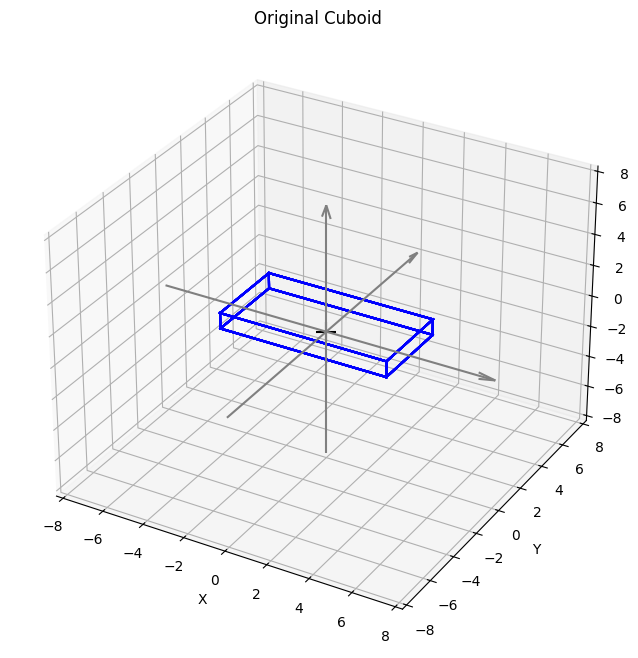

In [4]:
plot_cuboids(
    title='Original Cuboid',
    cuboids=[cuboid_coords], 
    colors=['b']
    )

## Cuboid rotation

In [5]:
# Definition of rotation angles
theta1, theta2, theta3 = 15, 45, 30

# Creation of the rotation matrics
Rx = create_rot_mat(theta1, 'x')
Ry = create_rot_mat(theta2, 'y')
Rz = create_rot_mat(theta3, 'z')
R = combine_rot_mats(Rx, Ry, Rz)

# Apply rotation to cuboid
cuboid_coords_rot = rotate(cuboid_coords, R)

### Visualization of rotated cuboid

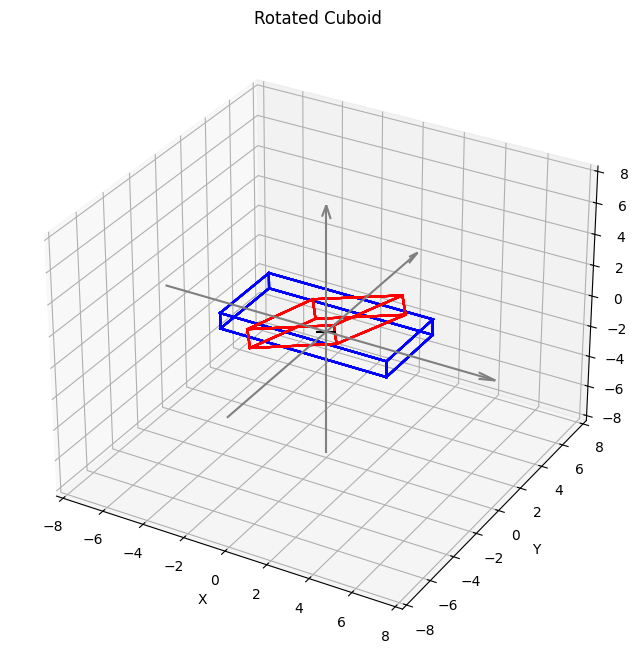

In [6]:
plot_cuboids(
    title='Rotated Cuboid',
    cuboids=[cuboid_coords, cuboid_coords_rot],
    colors=['b', 'r']
)

# Translation of rotated cuboid

In [7]:
# Definition of translation vector
translation_vec = np.array([3, 3, 3])

# Translating rotated cube
cuboid_coords_rot_tran = translate_cuboid(cuboid_coords_rot, translation_vec)

### Visualization of rotated and translated cuboid

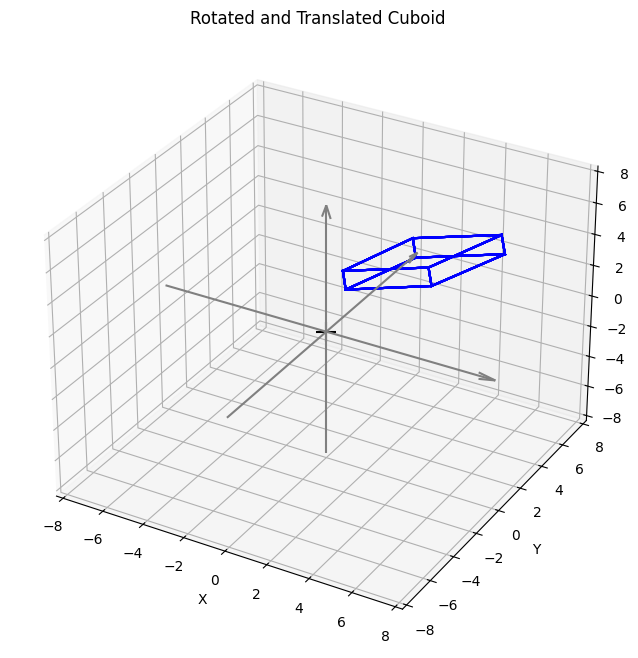

In [8]:
plot_cuboids(
    title='Rotated and Translated Cuboid',
    cuboids=[cuboid_coords_rot_tran],
    colors=['b']
)

## Visualization of all cuboids (original, rotated, rotated & translated)

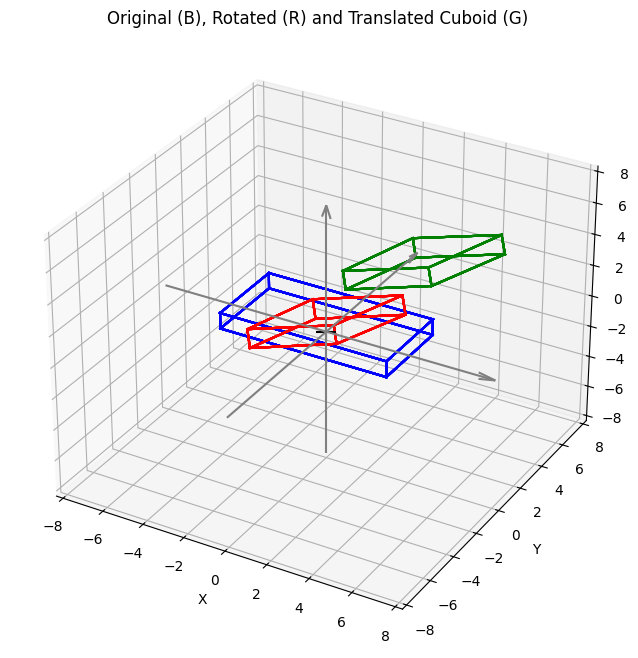

In [9]:
plot_cuboids(
    title='Original (B), Rotated (R) and Translated Cuboid (G)',
    cuboids=[cuboid_coords, cuboid_coords_rot, cuboid_coords_rot_tran],
    colors=['b', 'r', 'g']
)

## Cuboid Back-Translation and Centering

In [10]:
# Back-Translation and Centering of cuboid on origin
cuboid_coords_rot_centered = center_cuboid(cuboid_coords_rot_tran)

### Visualization of back-translated and centered cuboid

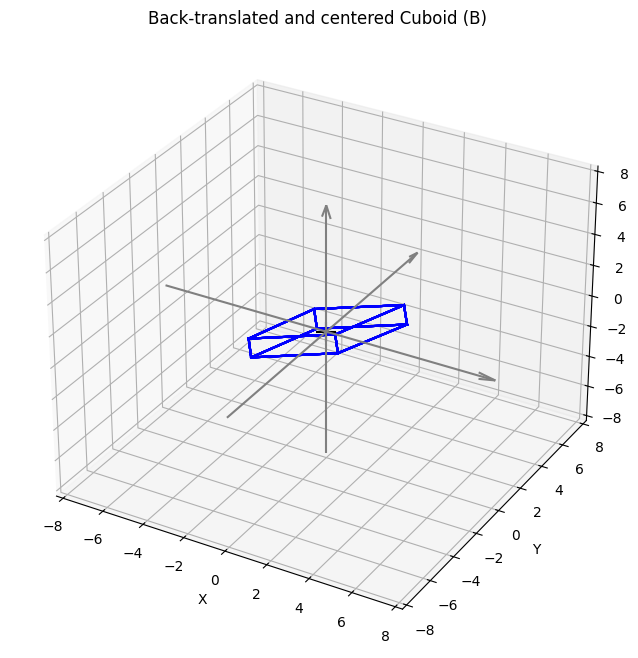

In [11]:
plot_cuboids(
    title='Back-translated and centered Cuboid (B)',
    cuboids=[cuboid_coords_rot_centered],
    colors=['b']
)

Talk about how the centering will differ from mere back translation vector applicaiton.

## Determination of orthonormal vector trio of "bounding box"

In [12]:
# retrieving lowest corner in z-direction
lowest_corner_coords = get_lowest_corner_coords(cuboid_coords_rot_centered, axis='z')

# TODO: Maybe make a function for this
# Construction of vectors to all other corners
lowest_corner_to_corner_vectors_list = []
for i in range(len(cuboid_coords_rot_centered)):
    lowest_corner_to_corner_i_vec = cuboid_coords_rot_centered[i] - lowest_corner_coords
    # Skip vector to the corner itself
    if (lowest_corner_to_corner_i_vec == np.array([0, 0, 0])).all():
        continue
    lowest_corner_to_corner_vectors_list.append(lowest_corner_to_corner_i_vec)
lowest_corner_to_corner_vectors = np.array(lowest_corner_to_corner_vectors_list)

# Determining the distances of all the vectors to pick the shortest one -> z-edge
lowest_corner_to_corner_dists = create_vec_distances(lowest_corner_to_corner_vectors)
shortest_lowest_corner_to_corner_dist = np.min(lowest_corner_to_corner_dists)
shortest_lowest_corner_to_corner_vector_idx = int(
    np.where(shortest_lowest_corner_to_corner_dist == shortest_lowest_corner_to_corner_dist)[0]
)
shortest_lowest_corner_to_corner_vector_coords = lowest_corner_to_corner_vectors[shortest_lowest_corner_to_corner_vector_idx]

# Calculating dot-product to check for angle with shortest vector 
orthonormal_vec_coords_list = []
for i in range(len(lowest_corner_to_corner_vectors)):
    dot_product_result = np.dot(
        shortest_lowest_corner_to_corner_vector_coords, 
        lowest_corner_to_corner_vectors[i]
    )
    if dot_product_result <= 0.0001:
        orthonormal_vec_coords_list.append(lowest_corner_to_corner_vectors[i])
orthonormal_vec_coords = np.array(orthonormal_vec_coords_list)

# Filtering out orthogonal lowest corner to corner vector which shouldnt be aligned with axes
orthonormal_corner_vector_distances = create_vec_distances(orthonormal_vec_coords_list)
longest_orthogonal_vec_dist = np.max(orthonormal_corner_vector_distances)
longest_orthogonal_vec_idx =  int(
    np.where(orthonormal_corner_vector_distances == longest_orthogonal_vec_dist)[0]
)
# Deletion of said vector and appending shortest vector
del orthonormal_vec_coords_list[longest_orthogonal_vec_idx]
orthonormal_vec_coords_list.append(shortest_lowest_corner_to_corner_vector_coords)
orthonormal_vec_coords = np.array(orthonormal_vec_coords_list)

/var/folders/g7/q6dyp4d97mdcwhfdvx5rp9n40000gn/T/ipykernel_8077/3960805880.py:19: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  np.where(shortest_lowest_corner_to_corner_dist == shortest_lowest_corner_to_corner_dist)[0]
/var/folders/g7/q6dyp4d97mdcwhfdvx5rp9n40000gn/T/ipykernel_8077/3960805880.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shortest_lowest_corner_to_corner_vector_idx = int(
/var/folders/g7/q6dyp4d97mdcwhfdvx5rp9n40000gn/T/ipykernel_8077/3960805880.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single

### Visualization of rotated and back-translated cuboid with orthonormal vectors

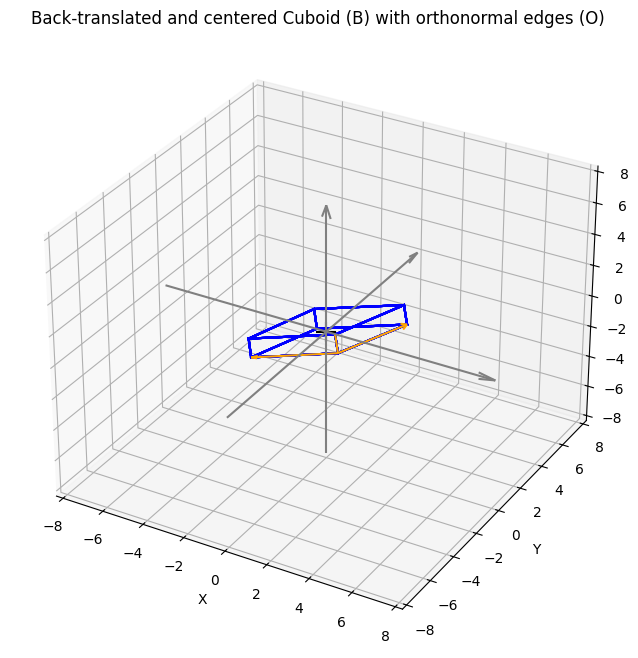

In [13]:
plot_cuboids(
    title='Back-translated and centered Cuboid (B) with orthonormal edges (O)',
    cuboids=[cuboid_coords_rot_centered],
    colors=['b'],
    orthonormal_vec_display=True, 
    orthonormal_vecs_start=lowest_corner_coords,
    orthonormal_vecs_coords=orthonormal_vec_coords, 
    orthonormal_vec_color='orange'
)

## First Rotation

Here the theory of the rotation will shortly be outlined....

In [14]:
# Pulling coordinates of the shortest, middle and longest orthonormal vector
z_edge = get_orthonormal_vec_coords(orthonormal_vec_coords, 'shortest')
y_edge = get_orthonormal_vec_coords(orthonormal_vec_coords, 'middle')
x_edge = get_orthonormal_vec_coords(orthonormal_vec_coords, 'longest')

# Determining the angle between y-edge and xy-plane
y_edge_xy_plane_angle_radians = vec_plane_angle(y_edge, np.array([0, 0, 1]))

# Creation of rotation matrix -> rotating around x-edge
R_rot1 = create_axis_angle_rot_mat(unit_vector(x_edge), y_edge_xy_plane_angle_radians)

# Rotation of cuboid vertices, orthonormal vectors and lowest corner
cuboid_coords_back_rot_1 = rotate(cuboid_coords_rot_centered, R_rot1)
orthonormal_vec_coords_back_rot_1 = rotate(orthonormal_vec_coords, R_rot1)
lowest_corner_coords_back_rot_1 = rotate(lowest_corner_coords, R_rot1)

# Centering rotated cuboid and auxiliaries
centered_cuboid_coords_back_rot_1 = center_cuboid(cuboid_coords_back_rot_1)
centered_orthonormal_vec_coords_back_rot_1 = center_with_cuboid(cuboid_coords_back_rot_1, 
                                                                orthonormal_vec_coords_back_rot_1)
centered_lowest_corner_coords_back_rot_1 = center_with_cuboid(cuboid_coords_back_rot_1, 
                                                              lowest_corner_coords_back_rot_1)


## Visualization of first rotation

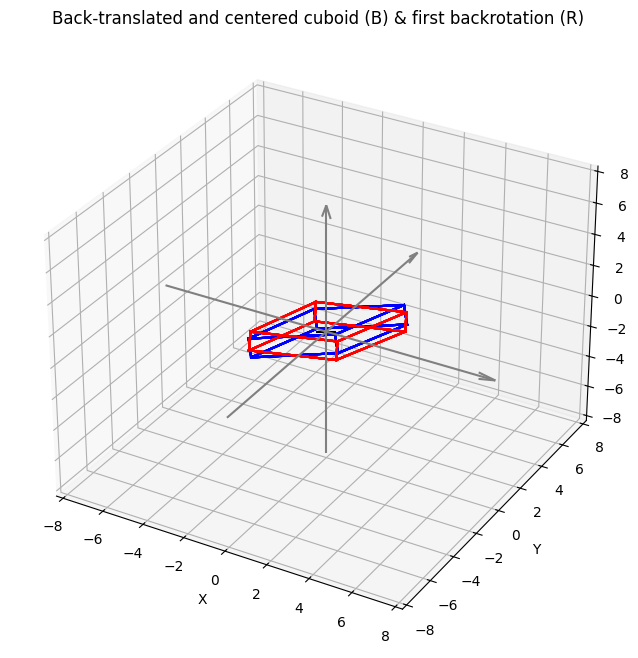

In [15]:
plot_cuboids(
    title='Back-translated and centered cuboid (B) & first backrotation (R)',
    cuboids=[cuboid_coords_rot_centered, centered_cuboid_coords_back_rot_1],
    colors=['b', 'r'],
)

## Second Rotation

Explanation of the second rotation will follow

In [16]:
# Pulling coordinates of the bounding box edges
z_edge = get_orthonormal_vec_coords(centered_orthonormal_vec_coords_back_rot_1, 'shortest')
y_edge = get_orthonormal_vec_coords(centered_orthonormal_vec_coords_back_rot_1, 'middle')
x_edge = get_orthonormal_vec_coords(centered_orthonormal_vec_coords_back_rot_1, 'longest')

# Determining the angle between y-edge and xz-plane
y_edge_xz_plane_angle_radians = np.pi/2 - vec_plane_angle(y_edge, np.array([0, 1, 0]))

# Creation of rotation matrix -> rotating around x-axis or z-edge -> TODO: test!!
R_rot2 = create_axis_angle_rot_mat(unit_vector(z_edge), y_edge_xz_plane_angle_radians)

# Rotation of cuboid, orthonormal vectors and lowest corner
cuboid_coords_back_rot_2 = rotate(centered_cuboid_coords_back_rot_1, R_rot2)
orthonormal_vec_coords_back_rot_2 = rotate(centered_orthonormal_vec_coords_back_rot_1, R_rot2)
lowest_corner_coords_back_rot_2 = rotate(centered_lowest_corner_coords_back_rot_1, R_rot2)

# Centering
centered_cuboid_coords_back_rot_2 = center_cuboid(cuboid_coords_back_rot_2)
centered_orthonormal_vec_coords_back_rot_2 = center_with_cuboid(cuboid_coords_back_rot_2, 
                                                                orthonormal_vec_coords_back_rot_2)
centered_lowest_corner_coords_back_rot_2 = center_with_cuboid(cuboid_coords_back_rot_2, 
                                                              lowest_corner_coords_back_rot_2)

### Visualization of second rotation

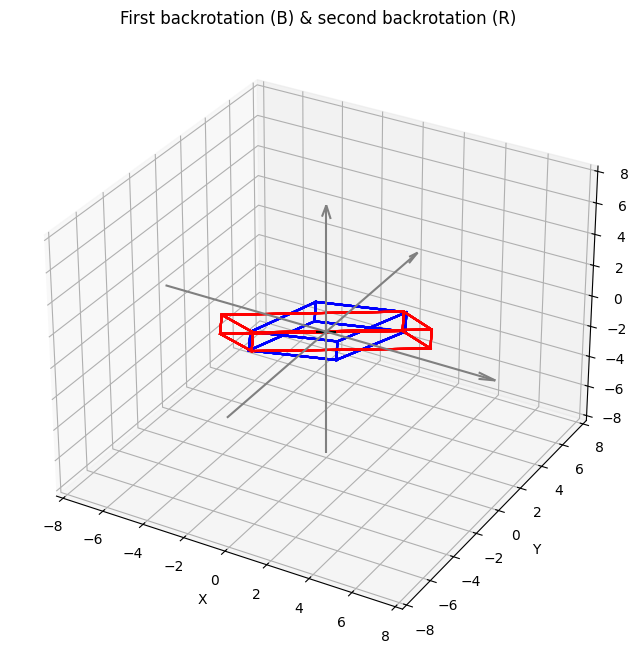

In [17]:
plot_cuboids(
    title='First backrotation (B) & second backrotation (R)',
    cuboids=[centered_cuboid_coords_back_rot_1, centered_cuboid_coords_back_rot_2],
    colors=['b', 'r'],
)

## Third Rotation

Explanation of third rotation will follow

In [18]:
# Pulling coordinates of the bounding box edges
z_edge = get_orthonormal_vec_coords(centered_orthonormal_vec_coords_back_rot_2, 'shortest')
y_edge = get_orthonormal_vec_coords(centered_orthonormal_vec_coords_back_rot_2, 'middle')
x_edge = get_orthonormal_vec_coords(centered_orthonormal_vec_coords_back_rot_2, 'longest')

# Determining the angle between x-edge and xy-plane around y_edge
x_edge_xy_plane_angle_radians = vec_plane_angle(unit_vector(x_edge), unit_vector(np.array([0, 0, 1])))
R_rot3 = create_axis_angle_rot_mat(unit_vector(y_edge), x_edge_xy_plane_angle_radians)

# Rotation of cuboid, orthonormal vectors and lowest corner
cuboid_coords_back_rot_3 = rotate(centered_cuboid_coords_back_rot_2, R_rot3)
orthonormal_vec_coords_back_rot_3 = rotate(centered_orthonormal_vec_coords_back_rot_2, R_rot3)
lowest_corner_coords_back_rot_3 = rotate(centered_lowest_corner_coords_back_rot_2, R_rot3)

# Centering
centered_cuboid_coords_back_rot_3 = center_cuboid(cuboid_coords_back_rot_3)
centered_orthonormal_vec_coords_back_rot_3 = center_with_cuboid(cuboid_coords_back_rot_3, 
                                                                orthonormal_vec_coords_back_rot_3)
centered_lowest_corner_coords_back_rot_3 = center_with_cuboid(cuboid_coords_back_rot_3, 
                                                              lowest_corner_coords_back_rot_3)

### Visualizing third rotation

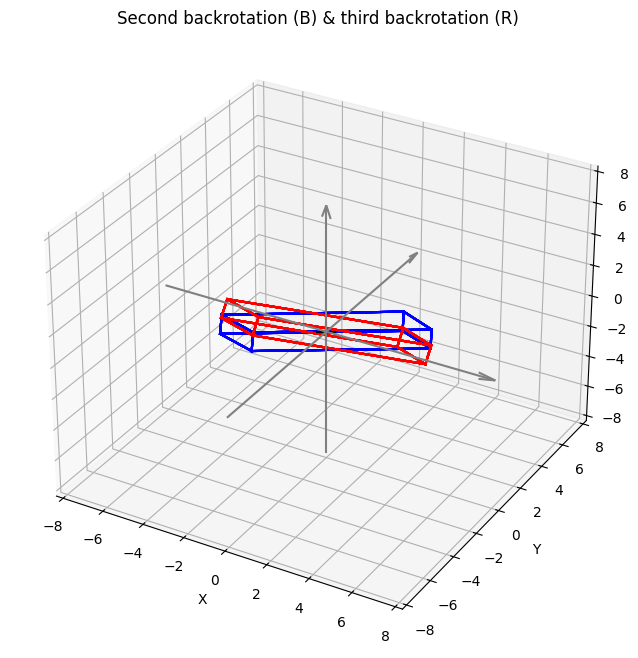

In [19]:
plot_cuboids(
    title='Second backrotation (B) & third backrotation (R)',
    cuboids=[centered_cuboid_coords_back_rot_2, centered_cuboid_coords_back_rot_3],
    colors=['b', 'r'],
)

In [20]:
centered_cuboid_coords_back_rot_3

array([[ 4.08216028, -1.23905567,  1.4320295 ],
       [-3.84274534, -2.1752695 ,  0.86689723],
       [-3.94802316,  0.50634606, -2.09922052],
       [ 3.97688247,  1.4425599 , -1.53408826],
       [ 3.94802316, -0.50634606,  2.09922052],
       [-3.97688247, -1.4425599 ,  1.53408826],
       [-4.08216028,  1.23905567, -1.4320295 ],
       [ 3.84274534,  2.1752695 , -0.86689723]])

# Conclusion